# Cleaning Kangaroo dataset

In [2269]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from peb_util import map_label_to_kwh

In [2270]:
df = pd.read_csv('./datasets/Kangaroo.csv')

### Drop duplicate rows

In [2271]:
df.drop_duplicates('id', inplace=True)

Drop useless columns

In [2272]:
df.drop(columns=['Unnamed: 0', 'id', 'url', 'locality', 'monthlyCost', 'hasBalcony', 'accessibleDisabledPeople'], inplace=True)

Replace values

In [2273]:
df['hasTerrace'].replace(pd.NA, False, inplace=True)
df['hasLivingRoom'].replace(pd.NA, False, inplace=True)
df['hasBasement'].replace(pd.NA, False, inplace=True)
df['hasLift'].replace(pd.NA, False, inplace=True)

df['hasVisiophone'].replace(pd.NA, False, inplace=True)
df['hasDiningRoom'].replace(pd.NA, False, inplace=True)
df['hasAttic'].replace(pd.NA, False, inplace=True)
df['hasOffice'].replace(pd.NA, False, inplace=True)
df['hasPhotovoltaicPanels'].replace(pd.NA, False, inplace=True)
df['hasHeatPump'].replace(pd.NA, False, inplace=True)
df['hasArmoredDoor'].replace(pd.NA, False, inplace=True)
df['hasThermicPanels'].replace(pd.NA, False, inplace=True)
df['hasFireplace'].replace(pd.NA, False, inplace=True)
df['hasDressingRoom'].replace(pd.NA, False, inplace=True)
df['hasSwimmingPool'].replace(pd.NA, False, inplace=True)
df['hasAirConditioning'].replace(pd.NA, False, inplace=True)

#assuming that if the surface is not specified, it is 0 (not present)
df['gardenSurface'].fillna(0.0, inplace=True)
df['livingRoomSurface'].fillna(0.0, inplace=True)
df['diningRoomSurface'].fillna(0.0, inplace=True)
df['terraceSurface'].fillna(0.0, inplace=True)
df['parkingCountIndoor'].fillna(0, inplace=True)
df['parkingCountOutdoor'].fillna(0, inplace=True)
df['landSurface'].fillna(0.0, inplace=True) #if landSurface missing > apartment

C:\Users\ImJus\AppData\Local\Temp\ipykernel_23760\691563469.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['hasTerrace'].replace(pd.NA, False, inplace=True)
C:\Users\ImJus\AppData\Local\Temp\ipykernel_23760\691563469.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['hasTerrace'].replac

Replace True_False with 1_0

In [2274]:
# Convert boolean columns to integers (True -> 1, False -> 0)
bool_columns = df.select_dtypes(include='bool').columns
for column in bool_columns:
    df[column] = df[column].astype(int)

# Verify the conversion
print(f"Converted {len(bool_columns)} boolean columns to integers:")
print(bool_columns.tolist())
print("\nDataFrame dtypes after conversion:")
print(df.dtypes.value_counts())

Converted 16 boolean columns to integers:
['hasAttic', 'hasBasement', 'hasDressingRoom', 'hasDiningRoom', 'hasLift', 'hasHeatPump', 'hasPhotovoltaicPanels', 'hasThermicPanels', 'hasLivingRoom', 'hasAirConditioning', 'hasArmoredDoor', 'hasVisiophone', 'hasOffice', 'hasSwimmingPool', 'hasFireplace', 'hasTerrace']

DataFrame dtypes after conversion:
float64    18
int64      17
object     11
Name: count, dtype: int64


Strip & Uppercase strings

In [2275]:
string_columns = df.select_dtypes(include='object').columns

for column in string_columns:
    # Apply strip and uppercase, but only to non-NaN string values
    df[column] = df[column].apply(lambda x: x.strip().upper() if isinstance(x, str) else x)
    
    # Count the modified values
    modified_count = df[column].notna().sum()
    
    # Print the result
    print(f"Processed column '{column}': {modified_count} values modified")

Processed column 'type': 80367 values modified
Processed column 'subtype': 80367 values modified
Processed column 'province': 80367 values modified
Processed column 'buildingCondition': 57991 values modified
Processed column 'floodZoneType': 44465 values modified
Processed column 'heatingType': 47153 values modified
Processed column 'kitchenType': 41916 values modified
Processed column 'hasGarden': 15957 values modified
Processed column 'gardenOrientation': 5600 values modified
Processed column 'terraceOrientation': 11262 values modified
Processed column 'epcScore': 65390 values modified


Convert PEB before removing province col

In [2276]:
df["epc_kwh"] = df.apply(map_label_to_kwh, axis=1)
df.drop(columns=['epcScore', 'province'], inplace=True)

Remove Outliers first

<Axes: >

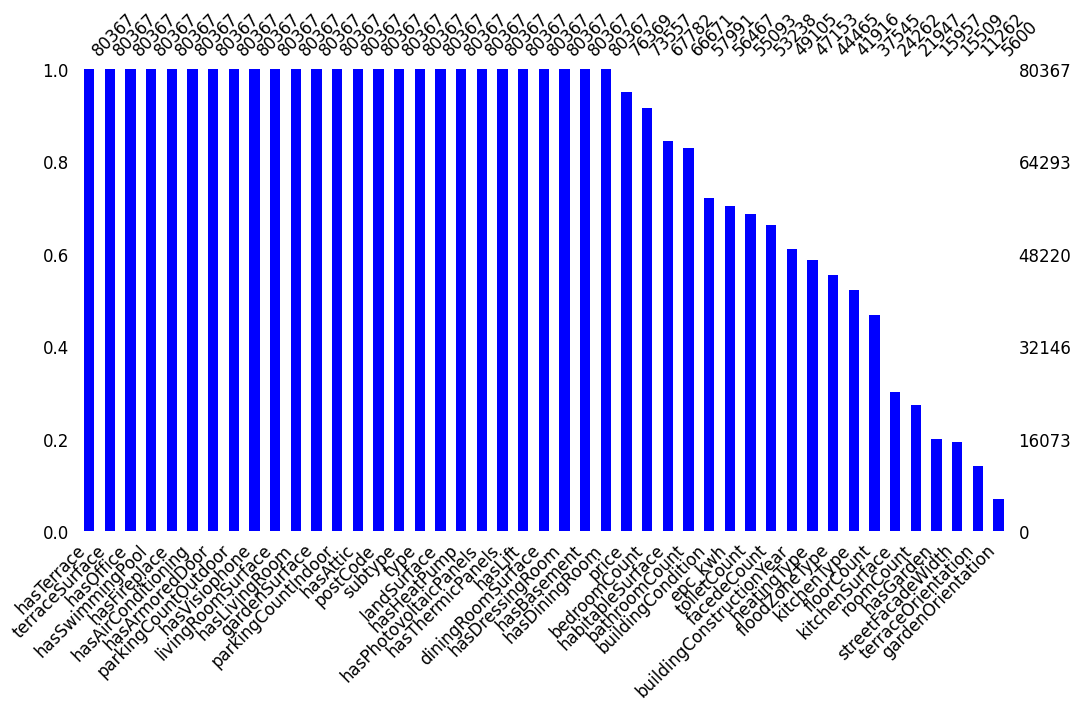

In [2277]:
msno.bar(df, figsize=(12, 6), color='blue', fontsize=12, sort='descending')

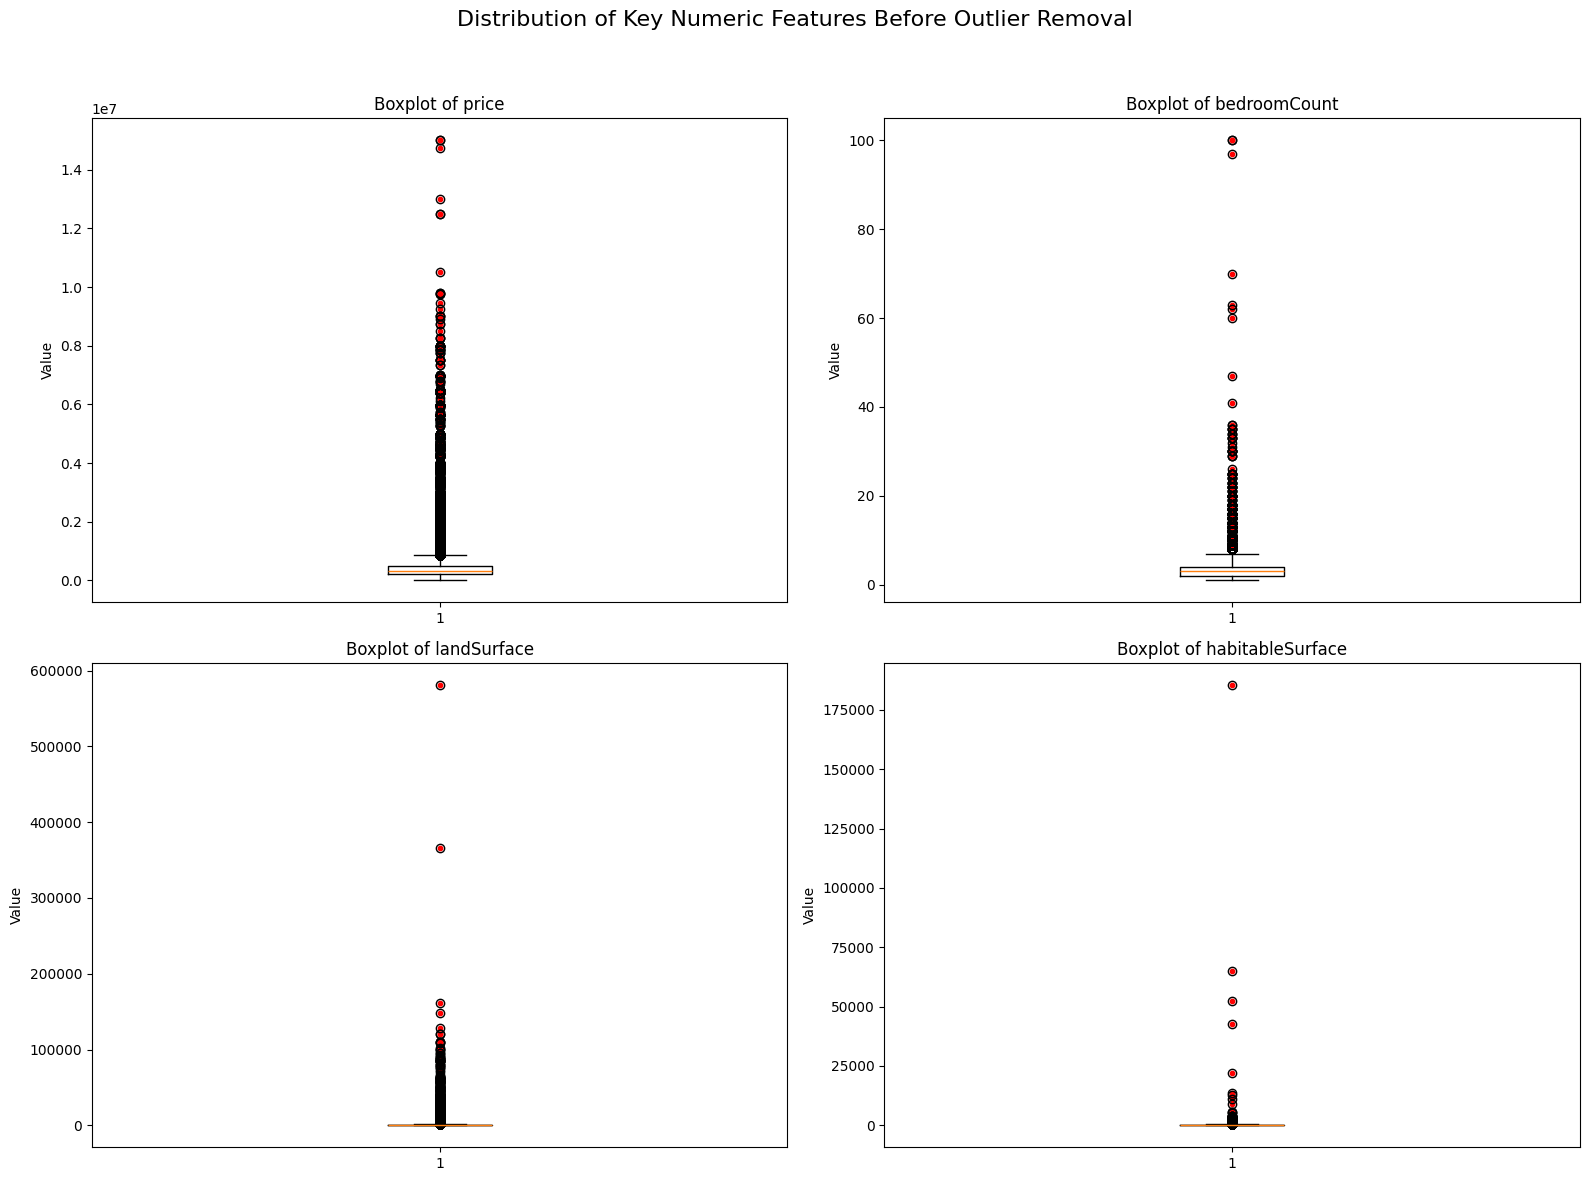

Total rows before removing outliers: 80367
Total rows after removing outliers: 59223
Total outliers removed: 21144
Percentage of data retained: 73.7%

Outliers removed per column:
  price: 6047 (7.5%)
  habitableSurface: 2998 (3.7%)
Total rows before removing outliers: 80367
Total rows after removing outliers: 59223
Total outliers removed: 21144
Percentage of data retained: 73.7%

Outliers removed per column:


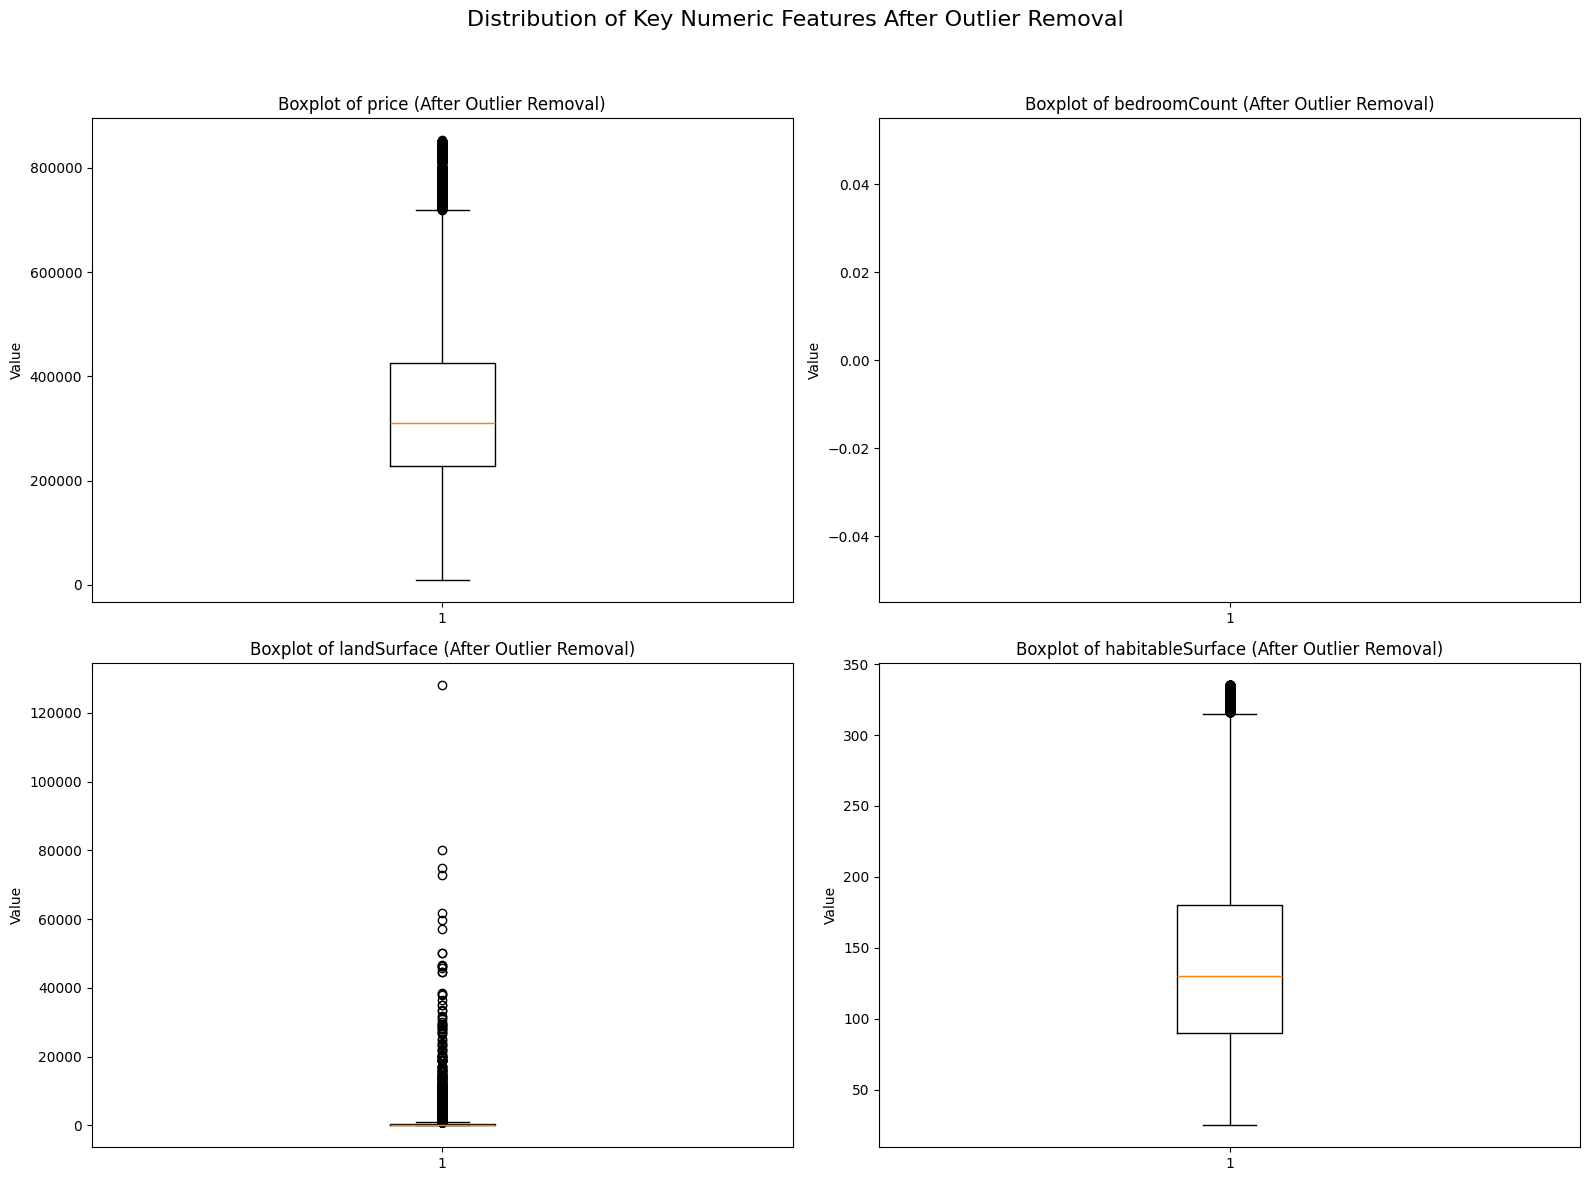

In [2278]:
#Thanks Copilot for this long piece of code 

def remove_outliers_iqr(df, columns, multiplier=1.5, min_thresholds=None):
    """
    Remove outliers from the dataframe using the IQR method.
    
    Parameters:
    df (pandas.DataFrame): The dataframe to process
    columns (list): List of column names to check for outliers
    multiplier (float): Multiplier for IQR to determine outlier threshold
    min_thresholds (dict): Dictionary with minimum threshold values for specific columns
    
    Returns:
    pandas.DataFrame: Dataframe with outliers removed
    """
    df_clean = df.copy()
    
    if min_thresholds is None:
        min_thresholds = {}
    
    outlier_counts = {}
    total_outliers = 0
    
    for column in columns:
        # Calculate Q1, Q3 and IQR
        Q1 = df_clean[column].quantile(0.25) #0.15
        Q3 = df_clean[column].quantile(0.75) #0.85
        IQR = Q3 - Q1
        
        # Calculate the outlier thresholds
        lower_bound = Q1 - (multiplier * IQR)
        upper_bound = Q3 + (multiplier * IQR)
        
        # Apply minimum threshold if specified
        if column in min_thresholds:
            lower_bound = max(lower_bound, min_thresholds[column])
        
        # Identify outliers
        outliers = df_clean[(df_clean[column] < lower_bound) | (df_clean[column] > upper_bound)]
        outlier_count = len(outliers)
        outlier_counts[column] = outlier_count
        total_outliers += outlier_count
        
        # Filter out the outliers
        df_clean = df_clean[(df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)]
    
    print(f"Total rows before removing outliers: {len(df)}")
    print(f"Total rows after removing outliers: {len(df_clean)}")
    print(f"Total outliers removed: {len(df) - len(df_clean)}")
    print(f"Percentage of data retained: {len(df_clean)/len(df)*100:.1f}%")
    print("\nOutliers removed per column:")
    
    for col, count in outlier_counts.items():
        print(f"  {col}: {count} ({count/len(df)*100:.1f}%)")
    
    return df_clean


# Let's visualize the distribution of key numeric columns before removing outliers
important_columns = ['price', 'bedroomCount', 'landSurface', 'habitableSurface']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distribution of Key Numeric Features Before Outlier Removal', fontsize=16)

for i, column in enumerate(important_columns):
    row, col = divmod(i, 2)
    
    # Create boxplot
    axes[row, col].boxplot(df[column].dropna())
    axes[row, col].set_title(f'Boxplot of {column}')
    axes[row, col].set_ylabel('Value')
    
    # Add some points to show extreme values
    outliers = df[abs(df[column] - df[column].mean()) > 3*df[column].std()][column]
    if not outliers.empty:
        axes[row, col].scatter(np.ones(len(outliers)), outliers, color='red', s=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Now remove outliers from key numeric columns
# Focus on columns highly correlated with price and most important for property valuation
columns_for_outlier_removal = [
    'price',
    # 'landSurface',
    'habitableSurface'
]

# Set minimum thresholds for landSurface to avoid unrealistic values
min_thresholds = {
    # 'landSurface': 0, # Minimum realistic land surface in square meters
    'habitableSurface' : 25
}  

df_clean = remove_outliers_iqr(df, columns_for_outlier_removal, multiplier=1.5, min_thresholds=min_thresholds)

print(f"Total rows before removing outliers: {len(df)}")
print(f"Total rows after removing outliers: {len(df_clean)}")
print(f"Total outliers removed: {len(df) - len(df_clean)}")
print(f"Percentage of data retained: {len(df_clean)/len(df)*100:.1f}%")
print("\nOutliers removed per column:")

# Visualize the distribution after outlier removal
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distribution of Key Numeric Features After Outlier Removal', fontsize=16)

for i, column in enumerate(important_columns):
    row, col = divmod(i, 2)
    
    # Create boxplot
    axes[row, col].boxplot(df_clean[column])
    axes[row, col].set_title(f'Boxplot of {column} (After Outlier Removal)')
    axes[row, col].set_ylabel('Value')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Update the dataframe
df = df_clean


In [2279]:
df['type'].unique() # Check integrity of the type column

array(['APARTMENT', 'HOUSE'], dtype=object)

### Imputing values after removing outliers

In [2280]:
df['kitchenType'].fillna(df['kitchenType'].mode()[0], inplace=True)
df['facedeCount'].fillna(int(df['facedeCount'].median()), inplace=True)
df['buildingConstructionYear'].fillna(int(df['buildingConstructionYear'].median()), inplace=True)
df['habitableSurface'].fillna(int(df['habitableSurface'].median()), inplace=True)
df['bathroomCount'].fillna(int(df['bathroomCount'].median()), inplace=True)
df['bedroomCount'].fillna(int(df['bedroomCount'].median()), inplace=True)

df['epc_kwh'].fillna(int(df['epc_kwh'].median()), inplace=True)

C:\Users\ImJus\AppData\Local\Temp\ipykernel_23760\1491790532.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['kitchenType'].fillna(df['kitchenType'].mode()[0], inplace=True)
C:\Users\ImJus\AppData\Local\Temp\ipykernel_23760\1491790532.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves 

### Converting values

Find trend and convert Building Condition according to it

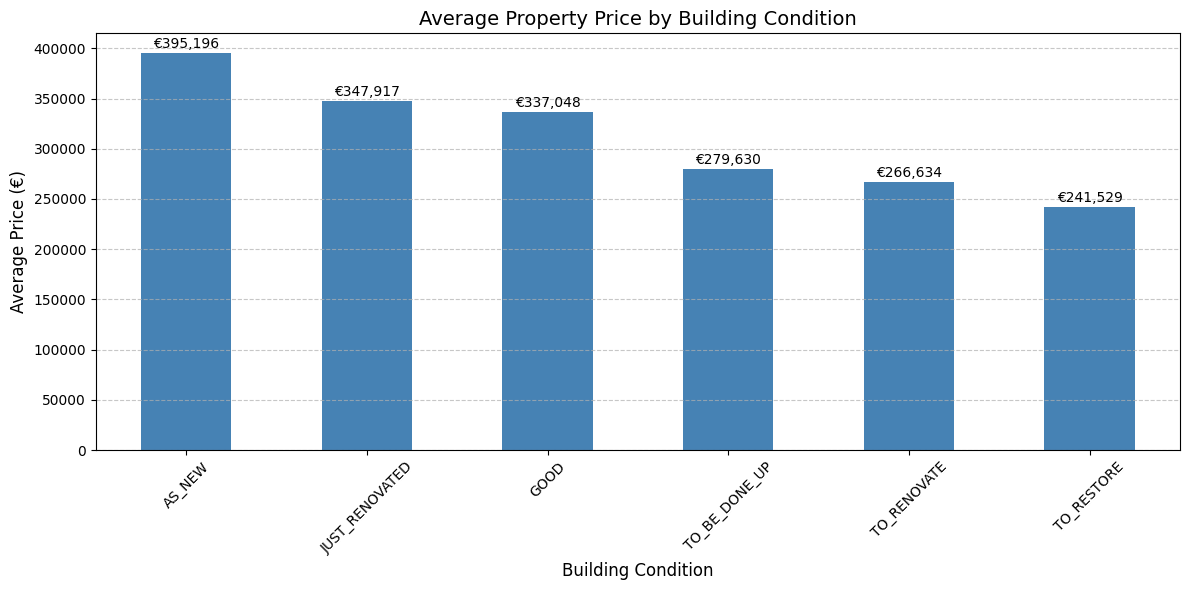

In [2281]:
# Calculate the average price per heating type
building_condition_price = df.groupby('buildingCondition')['price'].mean().sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
ax = building_condition_price.plot(kind='bar', color='steelblue')

# Add title and labels
plt.title('Average Property Price by Building Condition', fontsize=14)
plt.xlabel('Building Condition', fontsize=12)
plt.ylabel('Average Price (€)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for i, value in enumerate(building_condition_price):
    plt.text(i, value + 5000, f'€{value:,.0f}', ha='center', fontsize=10)

# Replace NaN in x-axis labels with "Not Specified"
labels = [item.get_text() if item.get_text() != 'nan' else 'Not Specified' 
          for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)

plt.tight_layout()
plt.show()

In [2282]:
label_to_score = {
    'TO_RESTORE': 0,
    'TO_RENOVATE': 1,
    'TO_BE_DONE_UP': 2,
    'GOOD': 3,
    'JUST_RENOVATED': 4,
    'AS_NEW': 5
}

df['buildingCondition'] = df['buildingCondition'].map(label_to_score)

df['buildingCondition'].fillna(int(df['buildingCondition'].median()), inplace=True)

C:\Users\ImJus\AppData\Local\Temp\ipykernel_23760\2007982498.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['buildingCondition'].fillna(int(df['buildingCondition'].median()), inplace=True)


Find trend for postalCode

In [2283]:
# # Calculate the average price per postalCode
postal_code_price = df.groupby('postCode')['price'].mean().round().sort_values(ascending=False)

df['postCode'] = df['postCode'].map(postal_code_price.to_dict())


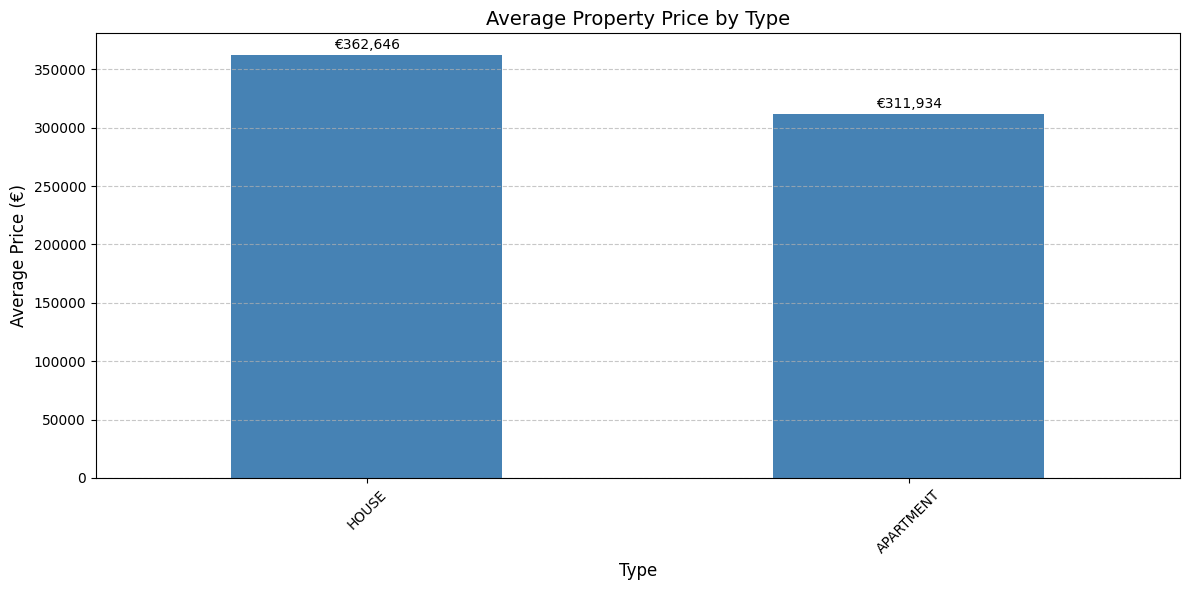

In [2284]:
# Calculate the average price per type_price
type_price = df.groupby('type')['price'].mean().round().sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
ax = type_price.plot(kind='bar', color='steelblue')

# Add title and labels
plt.title('Average Property Price by Type', fontsize=14)
plt.xlabel('Type', fontsize=12)
plt.ylabel('Average Price (€)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for i, value in enumerate(type_price):
    plt.text(i, value + 5000, f'€{value:,.0f}', ha='center', fontsize=10)

# Replace NaN in x-axis labels with "Not Specified"
labels = [item.get_text() if item.get_text() != 'nan' else 'Not Specified' 
          for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)

plt.tight_layout()
plt.show()

In [2285]:
label_to_score = {
    'APARTMENT': 0,
    'HOUSE': 1
}

df['type'] = df['type'].map(label_to_score)

Find trend and convert SubType according to it

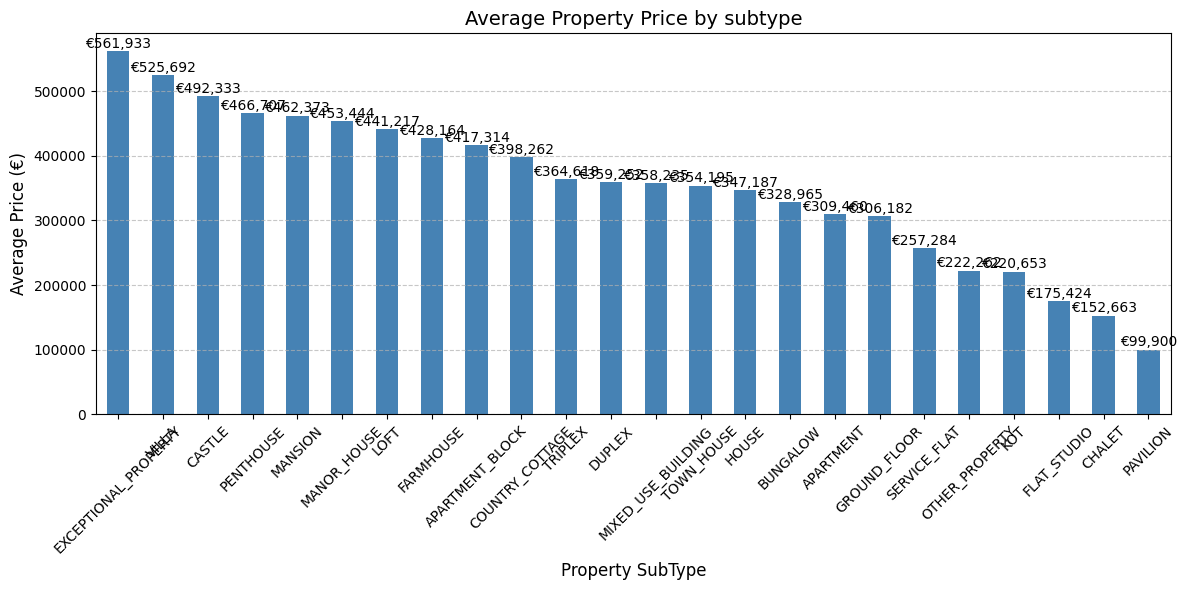

In [2286]:
# Calculate the average price per heating type
building_condition_price = df.groupby('subtype')['price'].mean().sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
ax = building_condition_price.plot(kind='bar', color='steelblue')

# Add title and labels
plt.title('Average Property Price by subtype', fontsize=14)
plt.xlabel('Property SubType', fontsize=12)
plt.ylabel('Average Price (€)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for i, value in enumerate(building_condition_price):
    plt.text(i, value + 5000, f'€{value:,.0f}', ha='center', fontsize=10)

# Replace NaN in x-axis labels with "Not Specified"
labels = [item.get_text() if item.get_text() != 'nan' else 'Not Specified' 
          for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)

plt.tight_layout()
plt.show()

In [2287]:
label_to_score = {
    'CHALET': 0,
    'OTHER_PROPERTY': 1,
    'BUNGALOW': 2,
    'TOWN_HOUSE': 3,
    'HOUSE': 4,
    'COUNTRY_COTTAGE': 5,
    'MIXED_USE_BUILDING': 6,
    'APARTMENT_BLOCK': 7,
    'MANOR_HOUSE': 8,
    'FARMHOUSE': 9,
    'CASTLE': 10,
    'MANSION': 11,
    'VILLA': 12,
    'EXCEPTIONAL_PROPERTY': 13
}

df['subtype'] = df['subtype'].map(label_to_score)

df['subtype'].fillna(int(df['subtype'].mode()[0]), inplace=True)

C:\Users\ImJus\AppData\Local\Temp\ipykernel_23760\4214724183.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['subtype'].fillna(int(df['subtype'].mode()[0]), inplace=True)


Find trend and convert FloodZoneType according to it

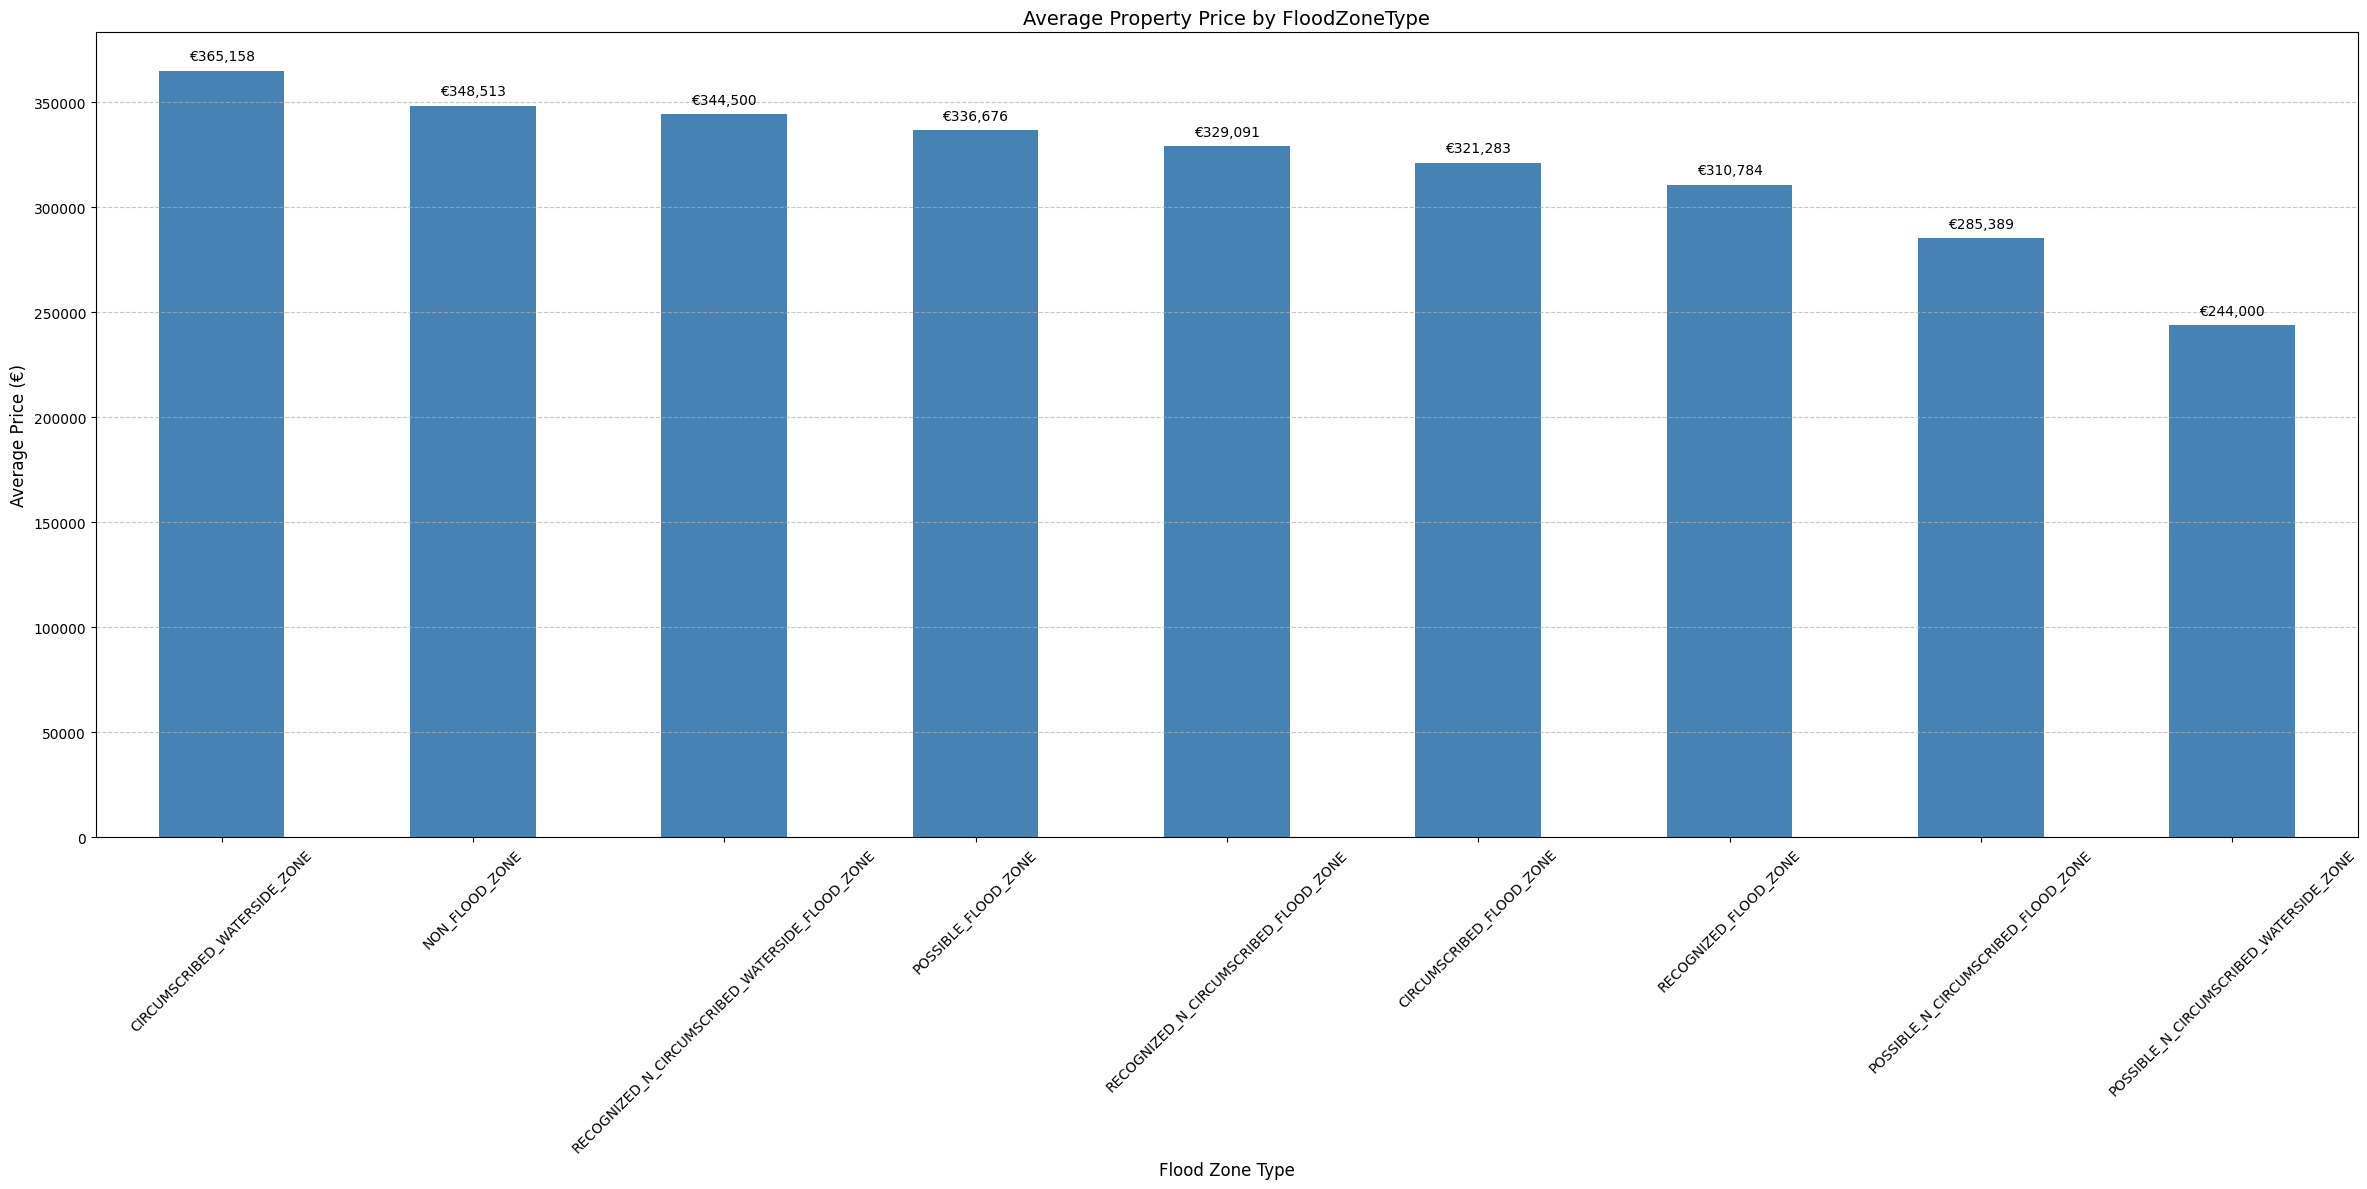

In [2288]:
# Calculate the average price per heating type
flood_zone_price = df.groupby('floodZoneType')['price'].mean().sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(24, 12))
ax = flood_zone_price.plot(kind='bar', color='steelblue')

# Add title and labels
plt.title('Average Property Price by FloodZoneType', fontsize=14)
plt.xlabel('Flood Zone Type', fontsize=12)
plt.ylabel('Average Price (€)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for i, value in enumerate(flood_zone_price):
    plt.text(i, value + 5000, f'€{value:,.0f}', ha='center', fontsize=10)

# Replace NaN in x-axis labels with "Not Specified"
labels = [item.get_text() if item.get_text() != 'nan' else 'Not Specified' 
          for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)

plt.tight_layout()
plt.show()

In [2289]:
label_to_score = {
    'NON_FLOOD_ZONE': 7,
    'CIRCUMSCRIBED_WATERSIDE_ZONE': 6, 
    'CIRCUMSCRIBED_FLOOD_ZONE': 5, 
    'POSSIBLE_FLOOD_ZONE': 4, 
    'RECOGNIZED_N_CIRCUMSCRIBED_FLOOD_ZONE': 3, 
    'POSSIBLE_N_CIRCUMSCRIBED_FLOOD_ZONE': 2, 
    'RECOGNIZED_FLOOD_ZONE': 1,
    'RECOGNIZED_N_CIRCUMSCRIBED_WATERSIDE_FLOOD_ZONE': 0
}

df['floodZoneType'] = df['floodZoneType'].map(label_to_score)

Find trend and convert HeatingType according to it

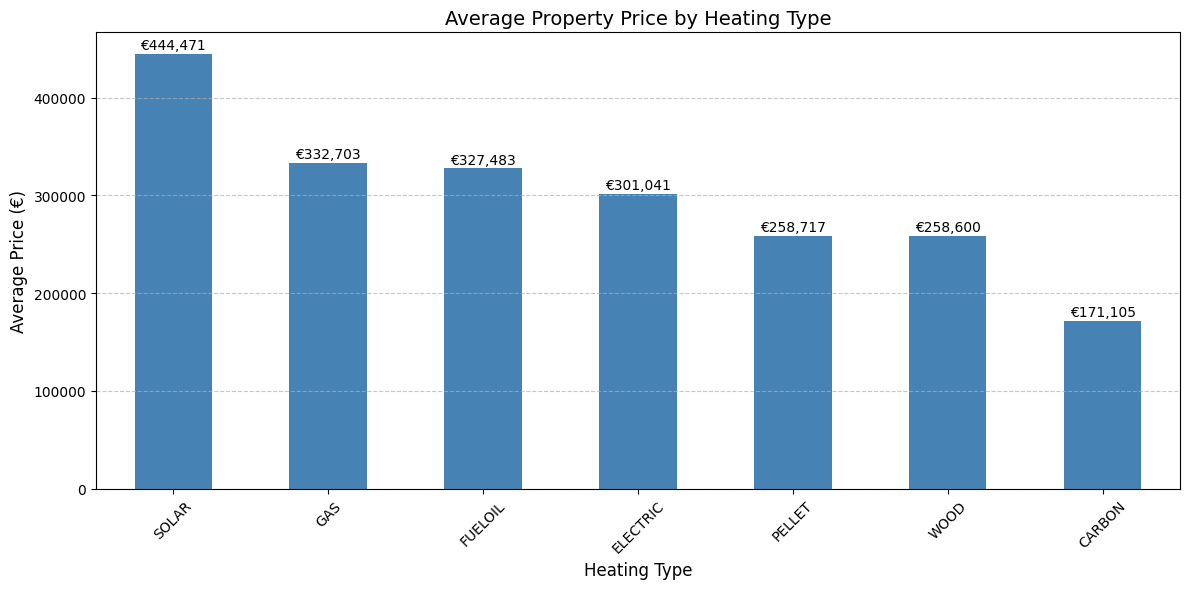

In [2290]:
# Calculate the average price per heating type
heating_price = df.groupby('heatingType')['price'].mean().sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
ax = heating_price.plot(kind='bar', color='steelblue')

# Add title and labels
plt.title('Average Property Price by Heating Type', fontsize=14)
plt.xlabel('Heating Type', fontsize=12)
plt.ylabel('Average Price (€)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for i, value in enumerate(heating_price):
    plt.text(i, value + 5000, f'€{value:,.0f}', ha='center', fontsize=10)

# Replace NaN in x-axis labels with "Not Specified"
labels = [item.get_text() if item.get_text() != 'nan' else 'Not Specified' 
          for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)

plt.tight_layout()
plt.show()

In [2291]:
label_to_score = {
    'CARBON' : 0,
    'PELLET' : 1,
    'WOOD' : 2,
    'FUELOIL' : 3,
    'ELECTRIC' : 4,
    'GAS' : 5,
    'SOLAR' : 6
}

df['heatingType'] = df['heatingType'].map(label_to_score)

df['heatingType'].fillna(df['heatingType'].median(), inplace=True)

C:\Users\ImJus\AppData\Local\Temp\ipykernel_23760\544111421.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['heatingType'].fillna(df['heatingType'].median(), inplace=True)


Find trend and convert KitchenType according to it

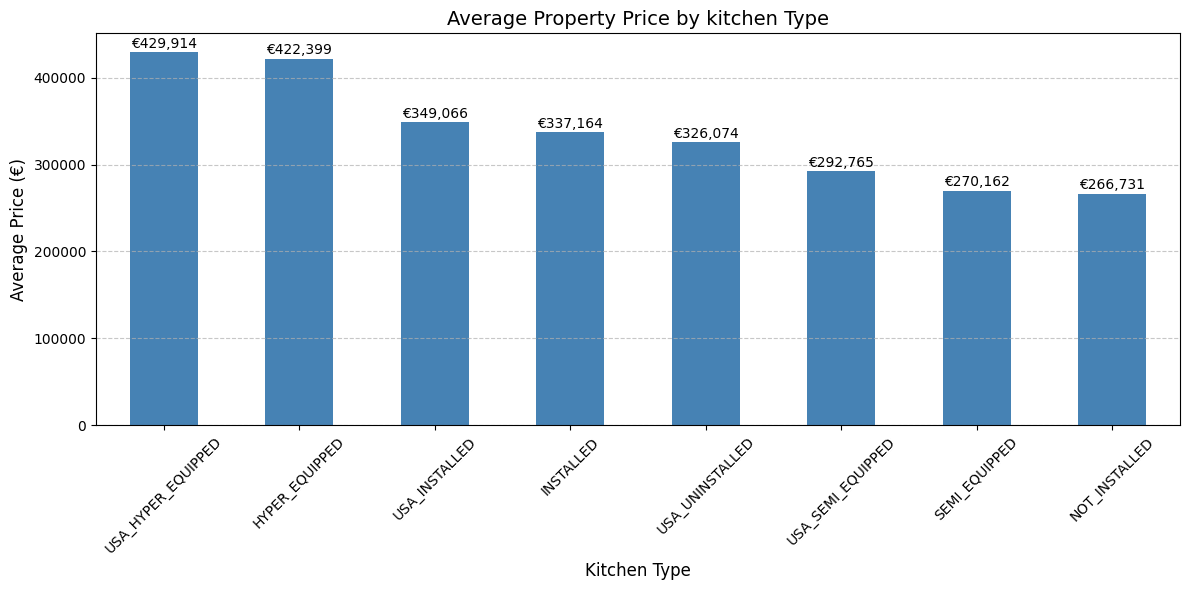

In [2292]:
# Calculate the average price per kitchenType
terrace_orientation_price = df.groupby('kitchenType')['price'].mean().sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
ax = terrace_orientation_price.plot(kind='bar', color='steelblue')

# Add title and labels
plt.title('Average Property Price by kitchen Type', fontsize=14)
plt.xlabel('Kitchen Type', fontsize=12)
plt.ylabel('Average Price (€)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for i, value in enumerate(terrace_orientation_price):
    plt.text(i, value + 5000, f'€{value:,.0f}', ha='center', fontsize=10)

# Replace NaN in x-axis labels with "Not Specified"
labels = [item.get_text() if item.get_text() != 'nan' else 'Not Specified' 
          for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)

plt.tight_layout()
plt.show()

In [2293]:
label_to_score = {
    'NOT_INSTALLED' : 0,
    'SEMI_EQUIPPED' : 1,
    'USA_UNINSTALLED' : 2,
    'USA_SEMI_EQUIPPED' : 3,
    'INSTALLED' : 4,
    'USA_INSTALLED' : 5,
    'HYPER_EQUIPPED' : 6,
    'USA_HYPER_EQUIPPED' : 7
}

df['kitchenType'] = df['kitchenType'].map(label_to_score)

Find trend and convert GardenOrientation into score

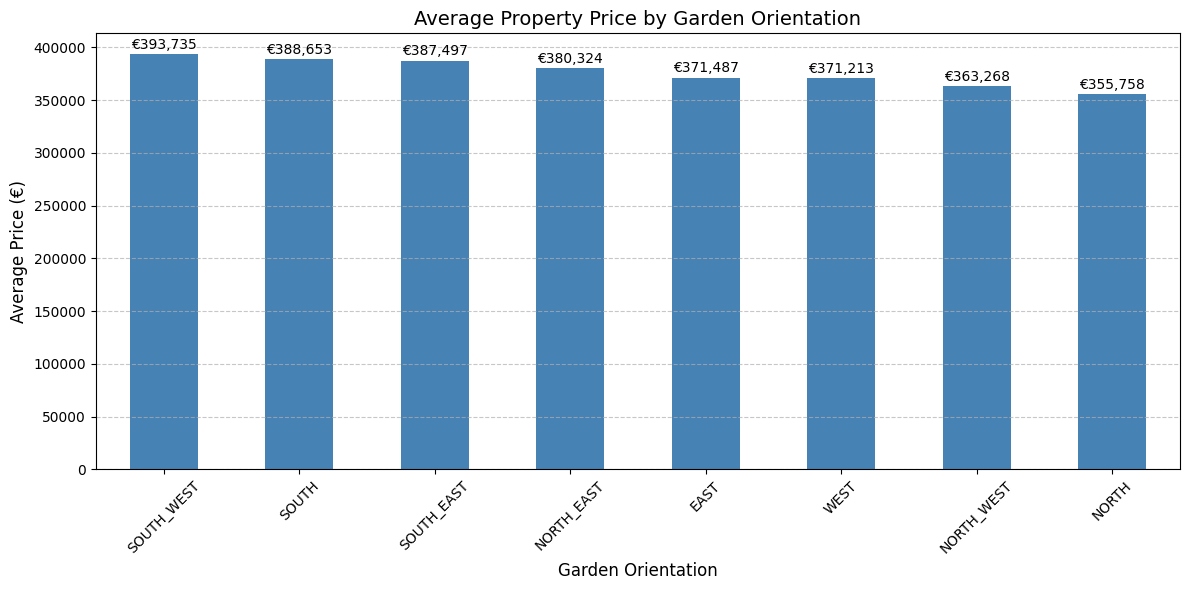

In [2294]:
# Calculate the average price per gardenOrientation
terrace_orientation_price = df.groupby('gardenOrientation')['price'].mean().sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
ax = terrace_orientation_price.plot(kind='bar', color='steelblue')

# Add title and labels
plt.title('Average Property Price by Garden Orientation', fontsize=14)
plt.xlabel('Garden Orientation', fontsize=12)
plt.ylabel('Average Price (€)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for i, value in enumerate(terrace_orientation_price):
    plt.text(i, value + 5000, f'€{value:,.0f}', ha='center', fontsize=10)

# Replace NaN in x-axis labels with "Not Specified"
labels = [item.get_text() if item.get_text() != 'nan' else 'Not Specified' 
          for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)

plt.tight_layout()
plt.show()

In [2295]:
label_to_score = {
    'NORTH' : 0,
    'NORTH_EAST' : 1,
    'NORTH_WEST' : 1,
    'EAST' : 1,
    'SOUTH' : 2,
    'WEST' : 2,
    'SOUTH_WEST' : 3,
    'SOUTH_EAST' : 4
}

df['gardenOrientation'] = df['gardenOrientation'].map(label_to_score)

Find trend and convert terraceOrientation to score


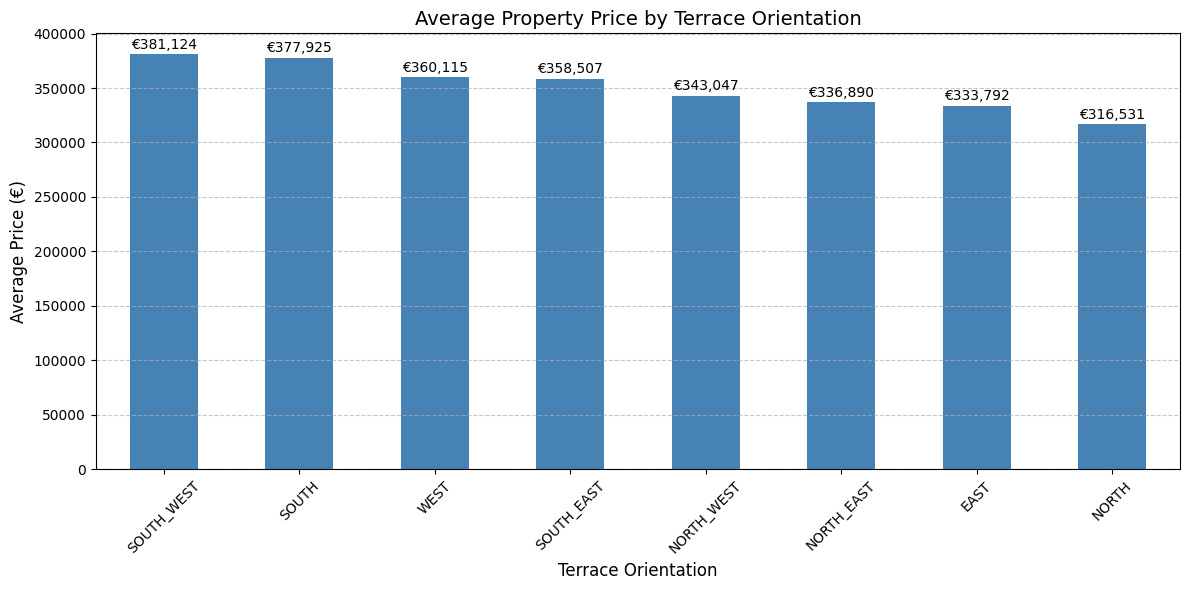

In [2296]:
# Calculate the average price per terraceOrientation
terrace_orientation_price = df.groupby('terraceOrientation')['price'].mean().sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
ax = terrace_orientation_price.plot(kind='bar', color='steelblue')

# Add title and labels
plt.title('Average Property Price by Terrace Orientation', fontsize=14)
plt.xlabel('Terrace Orientation', fontsize=12)
plt.ylabel('Average Price (€)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for i, value in enumerate(terrace_orientation_price):
    plt.text(i, value + 5000, f'€{value:,.0f}', ha='center', fontsize=10)

# Replace NaN in x-axis labels with "Not Specified"
labels = [item.get_text() if item.get_text() != 'nan' else 'Not Specified' 
          for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)

plt.tight_layout()
plt.show()

In [2297]:
label_to_score = {
    'NORTH' : 0,
    'EAST' : 1,
    'NORTH_EAST' : 1,
    'NORTH_WEST' : 2,
    'WEST' : 3,
    'SOUTH_EAST' : 4,
    'SOUTH' : 5,
    'SOUTH_WEST' : 6
}

df['terraceOrientation'] = df['terraceOrientation'].map(label_to_score)

Drop null prices rows

In [2298]:
df.dropna(subset='price', inplace=True)

Price Correlation Heatmap

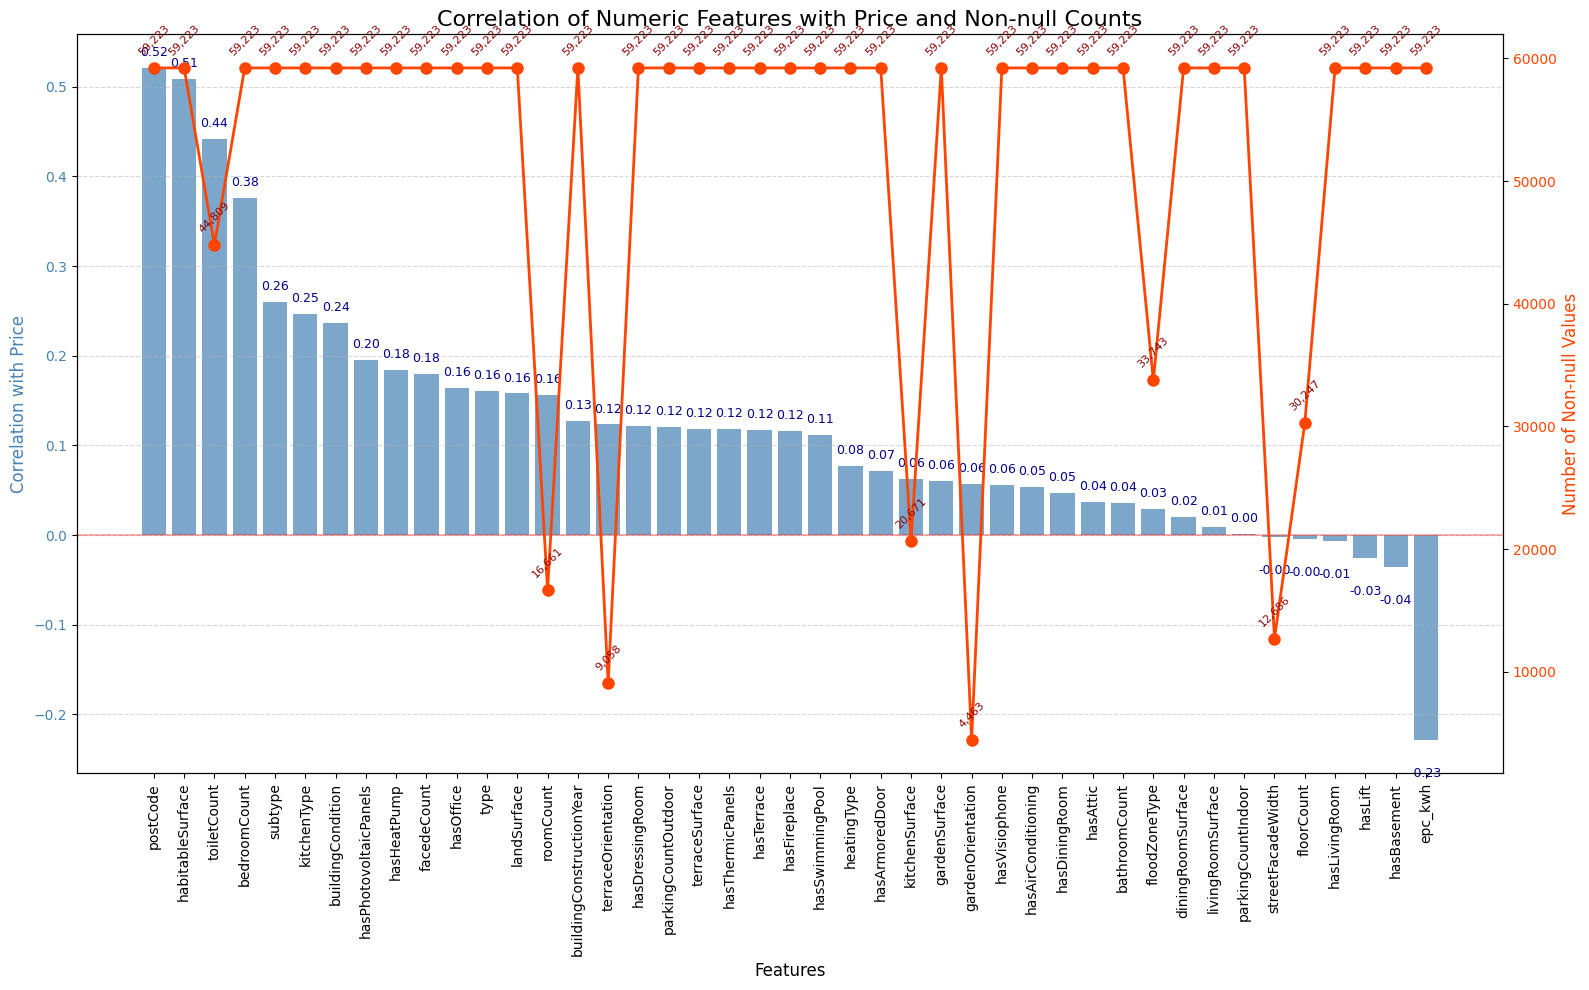

In [2299]:
# Select only numeric columns from the dataframe
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Create a dictionary to store correlations with price and non-null counts
price_correlations = {}
notna_counts = {}

# Calculate correlation of each numeric column with price and count non-null values
for column in numeric_columns:
    if column != 'price' and column != 'id':  # Exclude price itself and id
        correlation = df[column].corr(df['price'])
        price_correlations[column] = correlation
        notna_counts[column] = df[column].notna().sum()

# Convert to Series for easier plotting
price_corr_series = pd.Series(price_correlations).sort_values(ascending=False)
notna_count_series = pd.Series({k: notna_counts[k] for k in price_corr_series.index})

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(16, 10))
ax2 = ax1.twinx()

# Create a bar chart for correlations
bars = ax1.bar(price_corr_series.index, price_corr_series.values, color='steelblue', alpha=0.7)

# Add correlation values on top of the bars
for bar in bars:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2.,
        height + 0.01 if height >= 0 else height - 0.03,
        f'{height:.2f}',
        ha='center', va='bottom' if height >= 0 else 'top',
        fontsize=9, color='darkblue'
    )

# Create a line plot for non-null counts
ax2.plot(price_corr_series.index, notna_count_series.values, 'o-', color='orangered', linewidth=2, markersize=8)

# Add count labels above the line points
for i, count in enumerate(notna_count_series.values):
    ax2.text(i, count + 1000, f'{count:,}', ha='center', rotation=45, fontsize=8, color='darkred')

# Customize the plot
ax1.set_title('Correlation of Numeric Features with Price and Non-null Counts', fontsize=16)
ax1.set_xlabel('Features', fontsize=12)
ax1.set_ylabel('Correlation with Price', color='steelblue', fontsize=12)
ax2.set_ylabel('Number of Non-null Values', color='orangered', fontsize=12)
ax1.tick_params(axis='y', labelcolor='steelblue')
ax2.tick_params(axis='y', labelcolor='orangered')
ax1.set_xticks(range(len(price_corr_series.index)))
ax1.set_xticklabels(price_corr_series.index, rotation=90)
ax1.axhline(y=0, color='r', linestyle='-', alpha=0.3)
ax1.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Delete poorly correlated columns & too many missing values

In [2300]:
#+hasGarden because useless with gardenSurface
df.drop(columns=['kitchenSurface', 'hasDiningRoom', 'diningRoomSurface', 'hasLivingRoom', 'floorCount', 'streetFacadeWidth', 'hasAttic', 'gardenOrientation', 'hasGarden', 'terraceOrientation', 'roomCount', 'floodZoneType'], inplace=True)

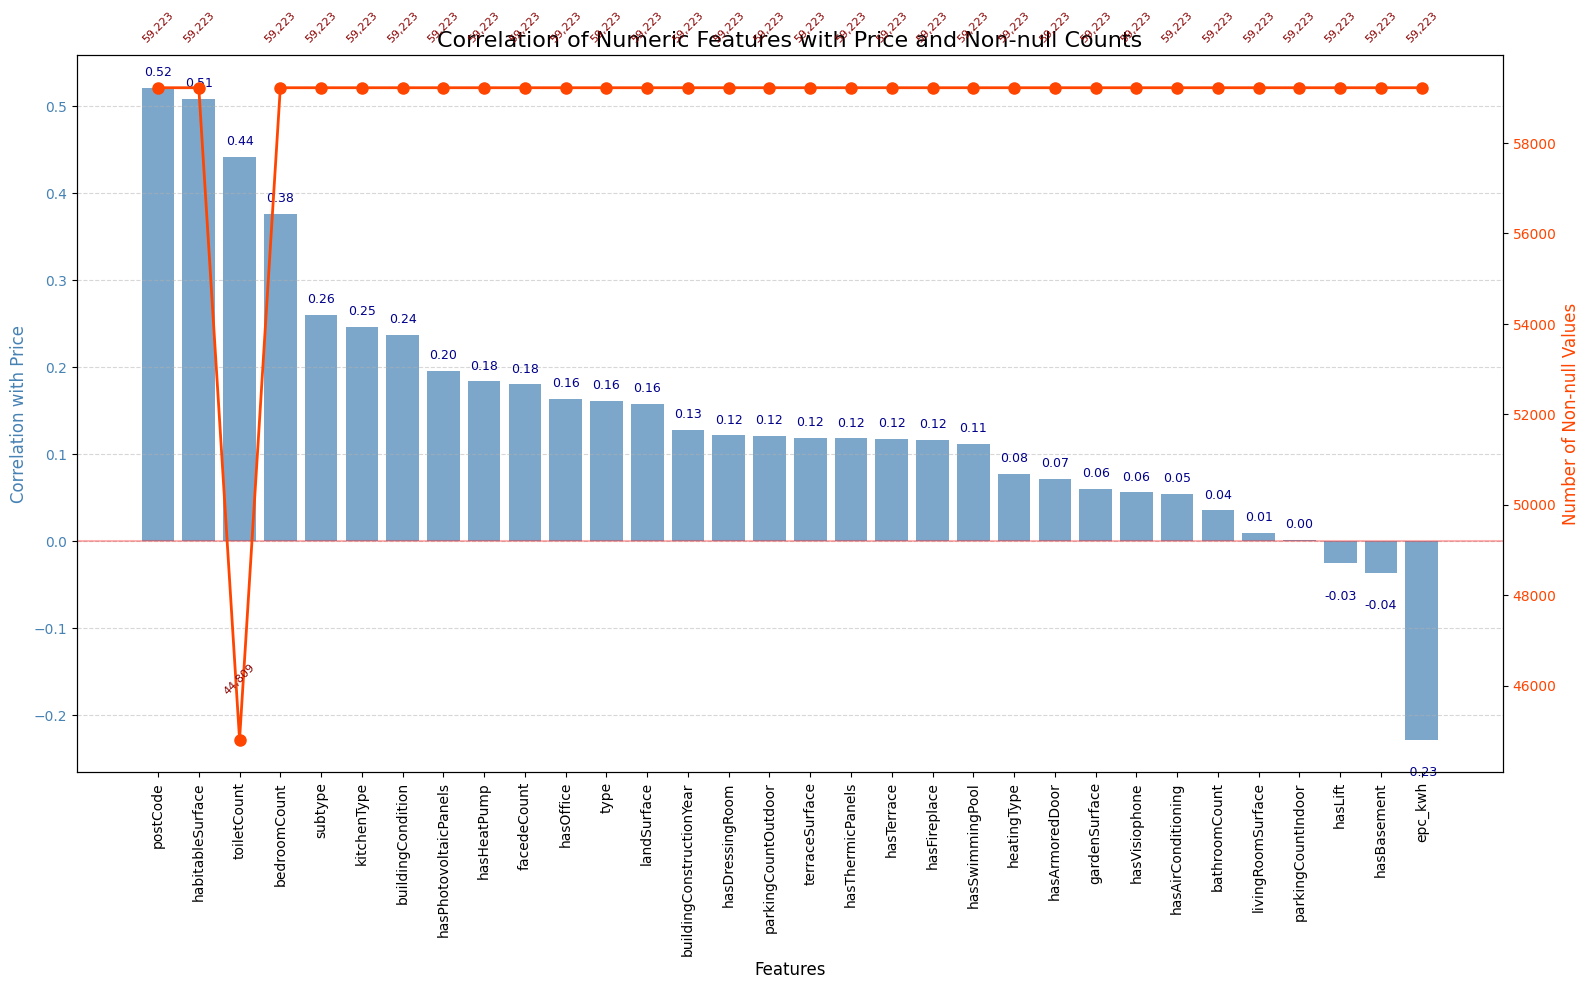

In [2301]:
# Select only numeric columns from the dataframe
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Create a dictionary to store correlations with price and non-null counts
price_correlations = {}
notna_counts = {}

# Calculate correlation of each numeric column with price and count non-null values
for column in numeric_columns:
    if column != 'price' and column != 'id':  # Exclude price itself and id
        correlation = df[column].corr(df['price'])
        price_correlations[column] = correlation
        notna_counts[column] = df[column].notna().sum()

# Convert to Series for easier plotting
price_corr_series = pd.Series(price_correlations).sort_values(ascending=False)
notna_count_series = pd.Series({k: notna_counts[k] for k in price_corr_series.index})

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(16, 10))
ax2 = ax1.twinx()

# Create a bar chart for correlations
bars = ax1.bar(price_corr_series.index, price_corr_series.values, color='steelblue', alpha=0.7)

# Add correlation values on top of the bars
for bar in bars:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2.,
        height + 0.01 if height >= 0 else height - 0.03,
        f'{height:.2f}',
        ha='center', va='bottom' if height >= 0 else 'top',
        fontsize=9, color='darkblue'
    )

# Create a line plot for non-null counts
ax2.plot(price_corr_series.index, notna_count_series.values, 'o-', color='orangered', linewidth=2, markersize=8)

# Add count labels above the line points
for i, count in enumerate(notna_count_series.values):
    ax2.text(i, count + 1000, f'{count:,}', ha='center', rotation=45, fontsize=8, color='darkred')

# Customize the plot
ax1.set_title('Correlation of Numeric Features with Price and Non-null Counts', fontsize=16)
ax1.set_xlabel('Features', fontsize=12)
ax1.set_ylabel('Correlation with Price', color='steelblue', fontsize=12)
ax2.set_ylabel('Number of Non-null Values', color='orangered', fontsize=12)
ax1.tick_params(axis='y', labelcolor='steelblue')
ax2.tick_params(axis='y', labelcolor='orangered')
ax1.set_xticks(range(len(price_corr_series.index)))
ax1.set_xticklabels(price_corr_series.index, rotation=90)
ax1.axhline(y=0, color='r', linestyle='-', alpha=0.3)
ax1.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Drop type & dropna

In [2302]:
# df.drop(columns='type', inplace=True)
df.dropna(inplace=True)

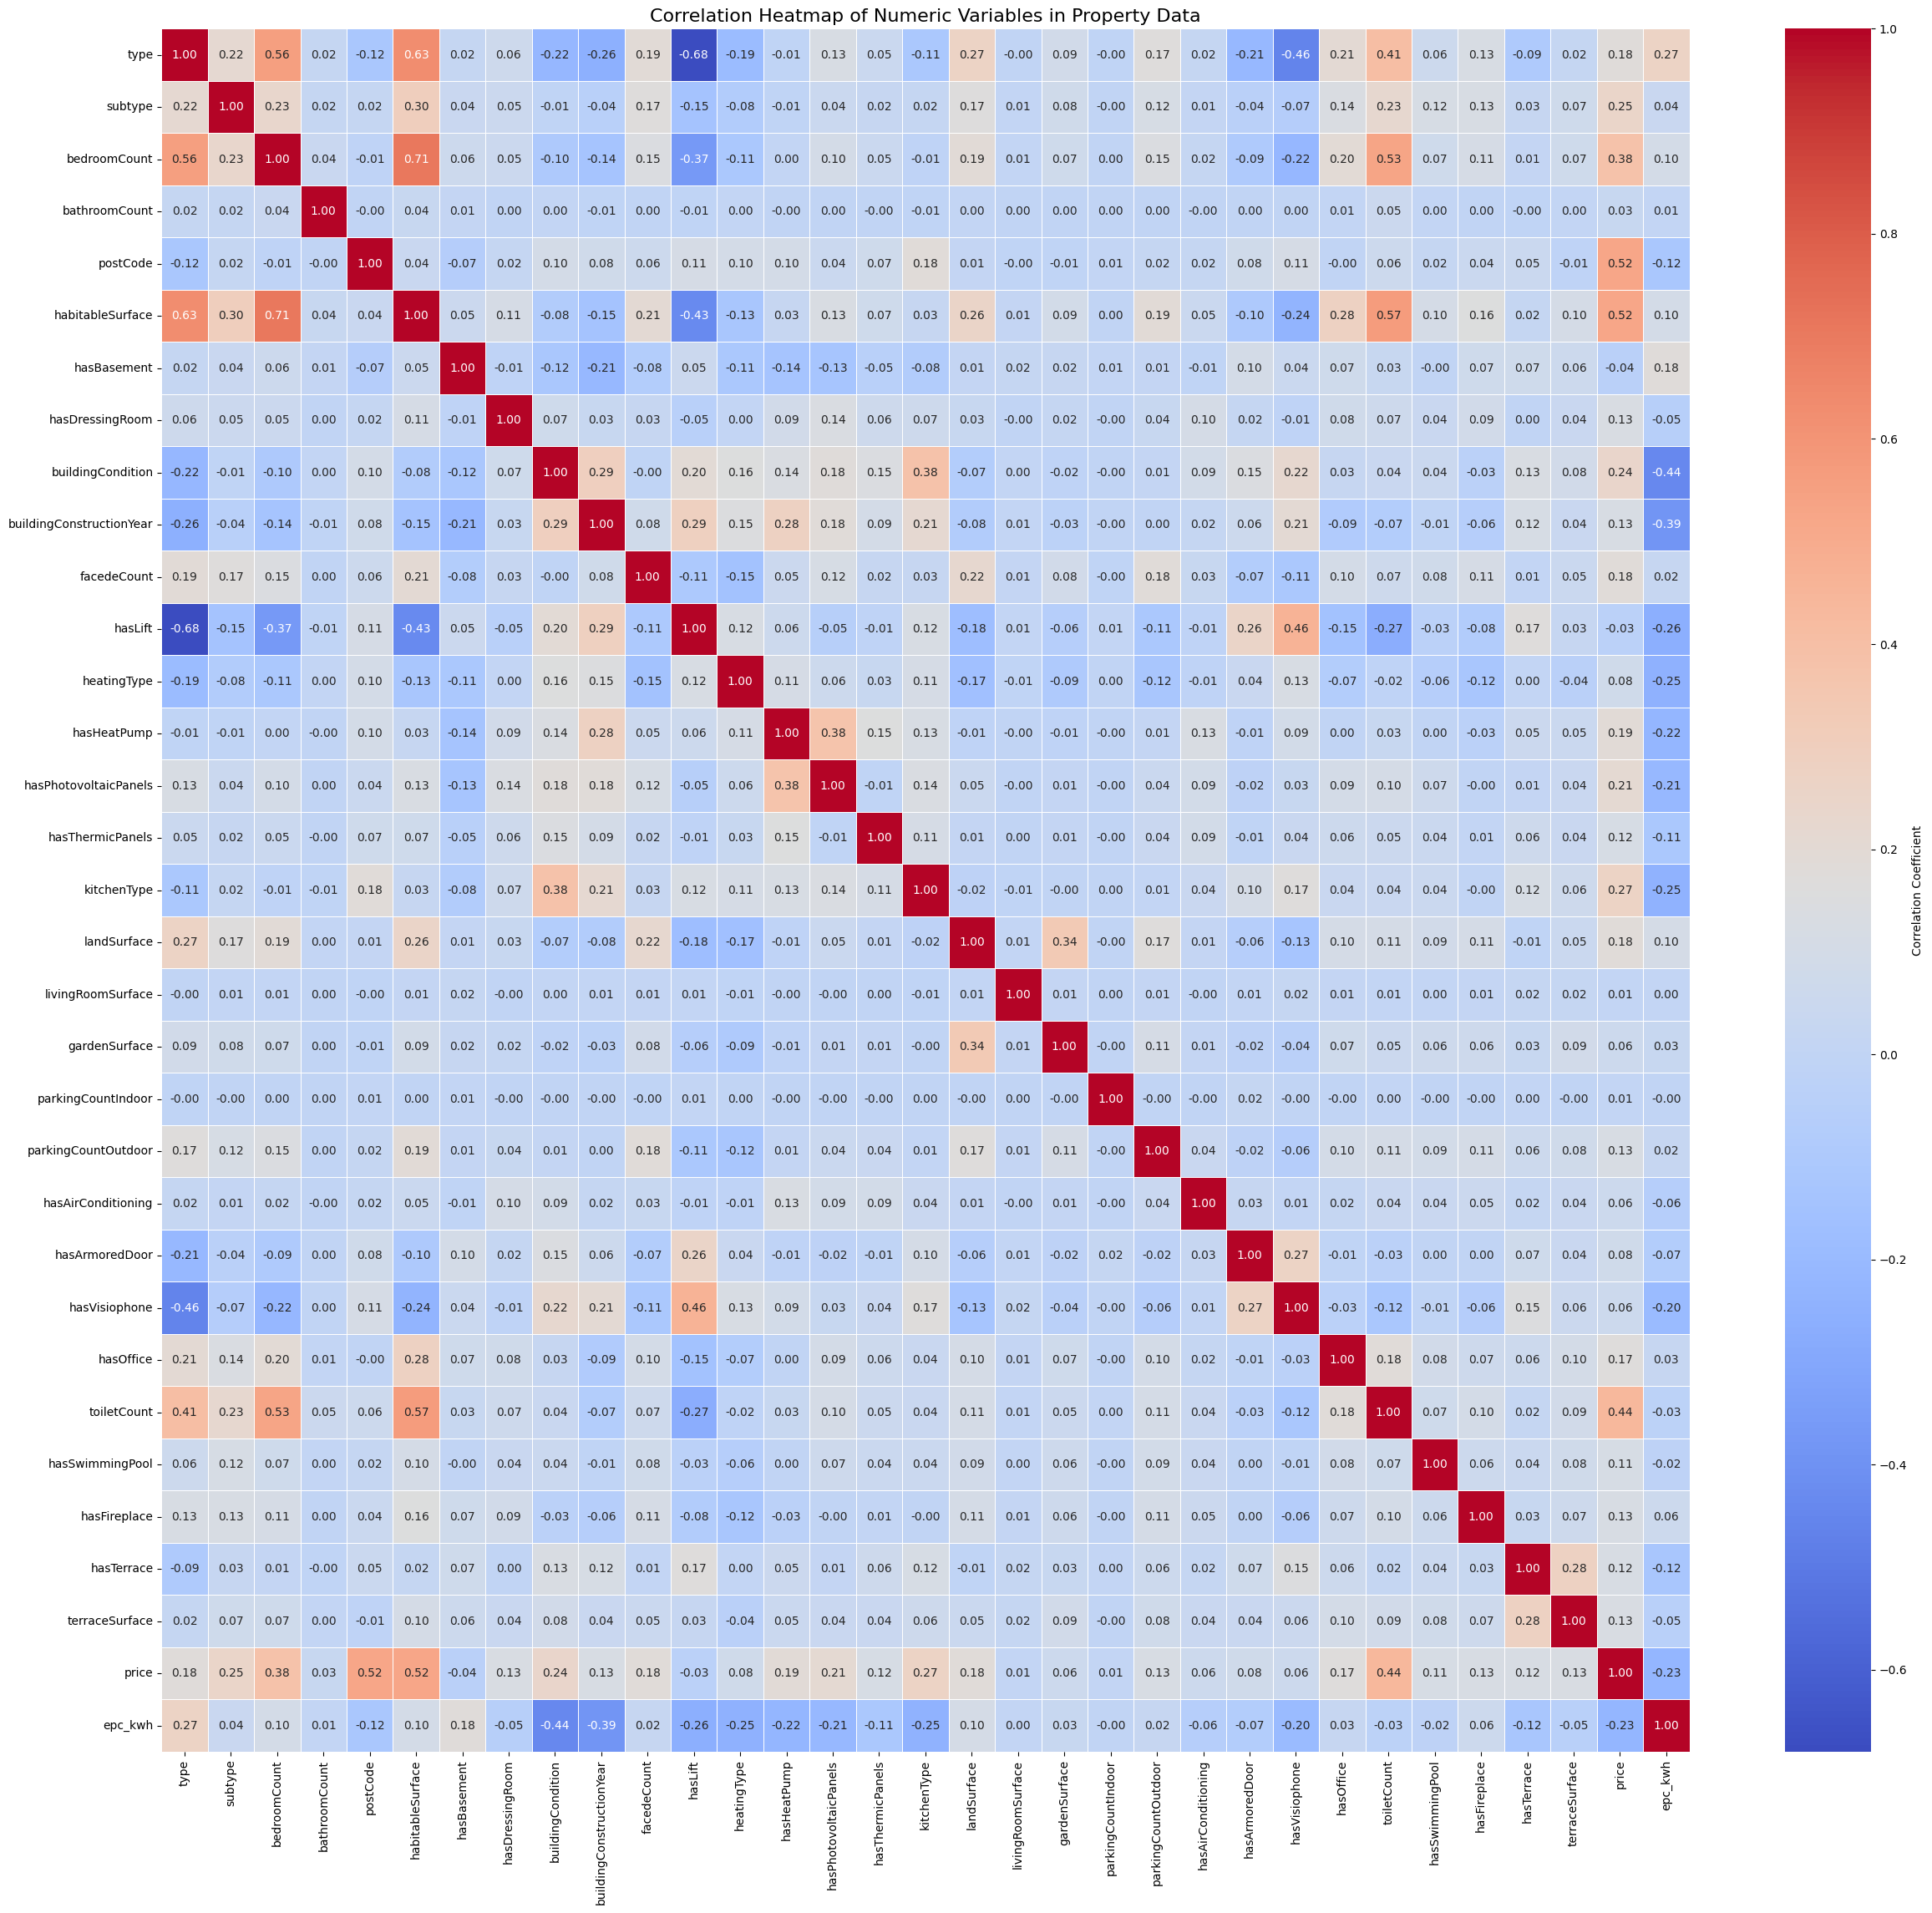

In [2303]:
# Calculate the correlation matrix, excluding propertyId
# Calculate the correlation matrix, selecting only numeric columns to avoid errors
correlation_matrix = df.select_dtypes(include=['int64', 'float64']).corr()

# Create a figure with appropriate size
plt.figure(figsize=(25, 23))

# Create a heatmap with value labels
heatmap = sns.heatmap(
    correlation_matrix, 
    annot=True,  # Show values on the heatmap
    cmap='coolwarm',  # Color map
    fmt='.2f',  # Format for the annotations (2 decimal places)
    linewidths=0.5,  # Width of the lines that divide each cell
    cbar_kws={'label': 'Correlation Coefficient'}  # Colorbar label
)

# Set title
plt.title('Correlation Heatmap of Numeric Variables in Property Data', fontsize=16)

# Adjust layout
plt.tight_layout()

# Display the heatmap
plt.show()

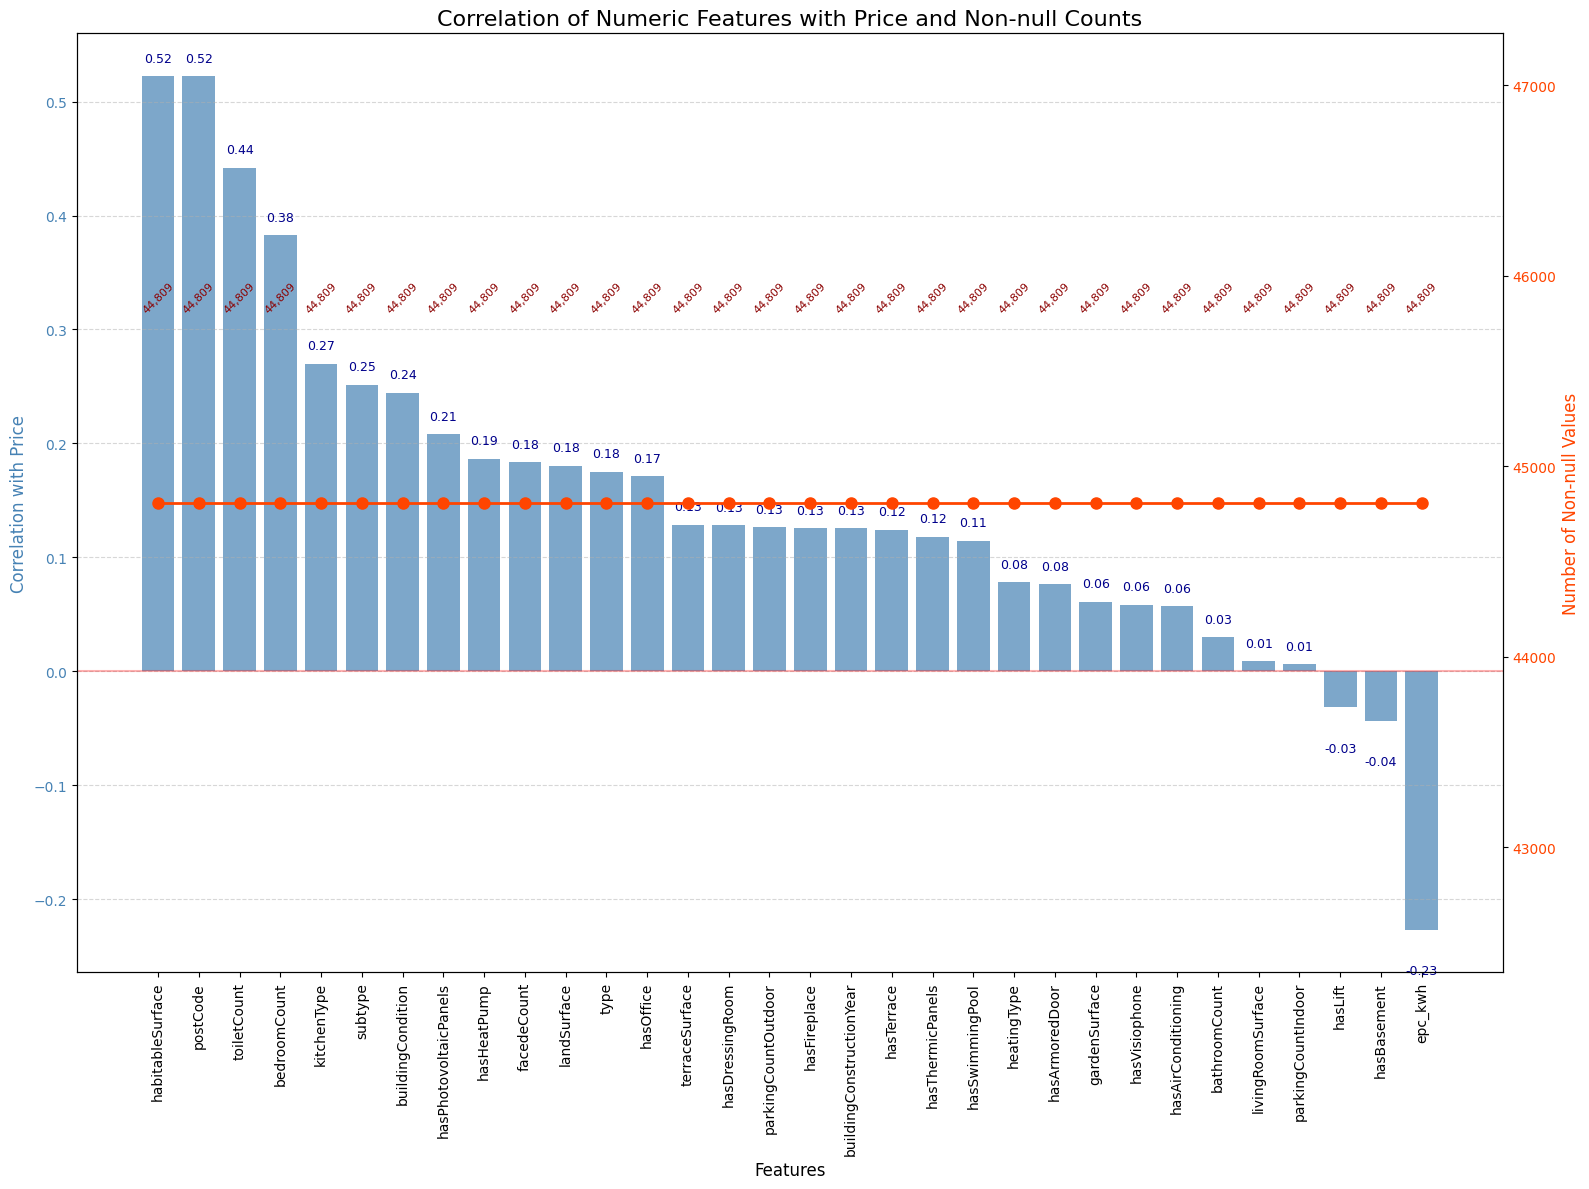

In [2304]:
# Select only numeric columns from the dataframe
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Create a dictionary to store correlations with price and non-null counts
price_correlations = {}
notna_counts = {}

# Calculate correlation of each numeric column with price and count non-null values
for column in numeric_columns:
    if column != 'price' and column != 'id':  # Exclude price itself and id
        correlation = df[column].corr(df['price'])
        price_correlations[column] = correlation
        notna_counts[column] = df[column].notna().sum()

# Convert to Series for easier plotting
price_corr_series = pd.Series(price_correlations).sort_values(ascending=False)
notna_count_series = pd.Series({k: notna_counts[k] for k in price_corr_series.index})

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(16, 12))
ax2 = ax1.twinx()

# Create a bar chart for correlations
bars = ax1.bar(price_corr_series.index, price_corr_series.values, color='steelblue', alpha=0.7)

# Add correlation values on top of the bars
for bar in bars:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2.,
        height + 0.01 if height >= 0 else height - 0.03,
        f'{height:.2f}',
        ha='center', va='bottom' if height >= 0 else 'top',
        fontsize=9, color='darkblue'
    )

# Create a line plot for non-null counts
ax2.plot(price_corr_series.index, notna_count_series.values, 'o-', color='orangered', linewidth=2, markersize=8)

# Add count labels above the line points
for i, count in enumerate(notna_count_series.values):
    ax2.text(i, count + 1000, f'{count:,}', ha='center', rotation=45, fontsize=8, color='darkred')

# Customize the plot
ax1.set_title('Correlation of Numeric Features with Price and Non-null Counts', fontsize=16)
ax1.set_xlabel('Features', fontsize=12)
ax1.set_ylabel('Correlation with Price', color='steelblue', fontsize=12)
ax2.set_ylabel('Number of Non-null Values', color='orangered', fontsize=12)
ax1.tick_params(axis='y', labelcolor='steelblue')
ax2.tick_params(axis='y', labelcolor='orangered')
ax1.set_xticks(range(len(price_corr_series.index)))
ax1.set_xticklabels(price_corr_series.index, rotation=90)
ax1.axhline(y=0, color='r', linestyle='-', alpha=0.3)
ax1.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### Finally save the cleaned dataset

In [2305]:
# Save the cleaned dataset to CSV
df.to_csv('./datasets/kangaroo-cleaned.csv', index=False)
print(f"Dataset saved with {len(df)} rows and {len(df.columns)} columns")

Dataset saved with 44809 rows and 33 columns
